* Formation Continue EMIASD, Univ. Paris Dauphine, Promo 6

* Author: Mohamed-Amine Baazizi
* Affiliation: LIP6 - Faculté des Sciences - Sorbonne Université
* Email: mohamed-amine.baazizi@lip6.fr
* Reusing without consent of the author is strictly forbidden
* July 2025

<p align="center">
  <a href="https://colab.research.google.com/github/auduvignac/Data_Lakehouse/blob/main/notebooks/project/delta_lake_usecase.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Ouvrir dans Google Colab"/>
  </a>
</p>

# Homework


## Outline

This homework is about building an effective data preparation pipeline.
It covers the following aspects covered throughout the session:

* ingest raw data, curate it, transform it
* load the data into delta tables to enforce constraints and allow updates
* chose an optimal data layout to speedup query evaluation

It is based on raw data about car prices crawled from a public source.

You are kindly asked to understand the data and decide about a relevant analysis (2 or 3 analytical queries) that can be performed on this data.
For example, you could suggest to derive insights (min, max, avg) about the price per year of registration.
You can use any other descriptive column that you may find useful.
You are also kindly invited to briefly comment the choices you made at each phase.








## Prerequisite

### System setup

In [153]:
!wget -q https://raw.githubusercontent.com/auduvignac/Data_Lakehouse/refs/heads/main/setup_env.py -O setup_env.py
%run setup_env.py

⚡ Exécution sur Colab : vérification stricte des dépendances…
✅ delta-spark 3.2.1 — OK
✅ parquet-tools 0.2.16 — OK
✅ pyngrok 7.3.0 — OK
✅ pyspark 3.5.3 — OK
✅ Toutes les dépendances satisfont les contraintes.


<Figure size 640x480 with 0 Axes>

In [154]:
%%capture
%pip install pyspark==3.5.3
%pip install -q delta-spark==3.2.1
%pip install pyngrok

In [155]:
!pip list|grep spark

dataproc-spark-connect                0.8.3
delta-spark                           3.2.1
pyspark                               3.5.3


In [156]:
import getpass
import shutil

import matplotlib.pyplot as plt
from pyngrok import (
    conf,
    ngrok,
)
from pyspark import SparkConf
from pyspark.sql import (
    Row,
    SparkSession,
)
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

In [157]:
local = "local[*]"
appName = "Formation Continue EMIASD - Delta Lake "
localConfig = (
    SparkConf()
    .setAppName(appName)
    .setMaster(local)
    .set("spark.executor.memory", "8G")
    .set("spark.driver.memory", "8G")
    .set("spark.sql.catalogImplementation", "in-memory")
    .set("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .set(
        "spark.sql.catalog.spark_catalog",
        "org.apache.spark.sql.delta.catalog.DeltaCatalog",
    )
    .set("spark.jars.packages", "io.delta:delta-spark_2.12:3.1.0")
    .set("spark.databricks.delta.schema.autoMerge.enabled", "true")
)

spark = SparkSession.builder.config(conf=localConfig).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [158]:
spark

### Data import

Before performing any analysis, we need to import the dataset into our working environment.  
This involves three main steps:  
1. Downloading and extracting the dataset archive.  
2. Checking the extracted files to confirm the dataset is available.  
3. Loading the CSV file into a Spark SQL table for further exploration and transformation.  

These steps ensure that the raw data is properly prepared and accessible for the data preparation pipeline.



#### Download and extract dataset

This section aims to fetch the dataset archive from the remote server and extract its contents locally in `/tmp/MLData`.




In [159]:
%%capture
!wget --no-verbose https://nuage.lip6.fr/s/89BG8HD9r3iE693/download/MLData.tgz -O /tmp/MLData.tgz
!tar -xzvf /tmp/MLData.tgz  --directory /tmp/

The command above is used to download and extract the dataset.  
Since the dataset is distributed as a compressed `.tgz` archive, we first fetch it with `wget` and then unpack it into `/tmp/MLData` using `tar`.  
The `%%capture` magic is applied to hide the verbose output and keep the notebook tidy.

#### Check extracted files

This section aims to verify that the dataset has been correctly extracted and explore the available files.


In [160]:
!ls -hal /tmp/MLData

total 73M
drwxr-xr-x 2  501 staff 4.0K Jan  6  2022 .
drwxrwxrwt 1 root root   20K Sep 13 16:23 ..
-rw-r--r-- 1  501 staff  66M Jan  6  2022 autos.csv
-rw-r--r-- 1  501 staff  176 Jan  6  2022 ._loan.csv
-rw-r--r-- 1  501 staff 6.8M Jan  6  2022 loan.csv


The command above lists the contents of `/tmp/MLData` along with file sizes.
From here, we confirm the presence of `autos.csv`, which is the main dataset we will use for our analysis.

#### Load dataset into Spark table

The following query aims to create a Spark SQL table from the raw CSV file so that we can query the data efficiently.

```sql
CREATE TABLE IF NOT EXISTS raw_vehiculePrices
USING csv
OPTIONS (
  header "true",
  path "/tmp/MLData/autos.csv",
  inferSchema "true"
)
```

We define a new table `raw_vehiculePrices` using the CSV file `autos.csv`.

- `header "true"` ensures the first row is used as column names ;
- `inferSchema "true"` allows Spark to automatically detect column data types ;

This creates a structured table in Spark SQL, making it easier to explore and transform the dataset in the next steps.

In [161]:
sc.setJobDescription(
    "[Data Import] Load raw car prices data from CSV into raw_vehiculePrices table"
)
query = """
CREATE TABLE IF NOT EXISTS raw_vehiculePrices
USING csv
OPTIONS (
  header "true",
  path "/tmp/MLData/autos.csv",
  inferSchema "true"
)
"""
spark.sql(query)

DataFrame[]

## Phase 0: Understanding the data






In this part, you are invited to get some knowledge about the data by reading its schema and extracting  some basic statistical information about the values of columns that you will find interesting.

### Schema exploration

#### Objective

Before analyzing the data, we want to understand its structure. The `DESCRIBE` command shows the schema of the table, including column names, data types, and roles.

#### Query

```sql
DESCRIBE raw_vehiculePrices
```

In [162]:
sc.setJobDescription("[Phase 0] Describe schema of raw_vehiculePrices table")
query = """
DESCRIBE raw_vehiculePrices
"""
spark.sql(query).show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|        dateCrawled|timestamp|   NULL|
|               name|   string|   NULL|
|             seller|   string|   NULL|
|          offerType|   string|   NULL|
|              price|      int|   NULL|
|             abtest|   string|   NULL|
|        vehicleType|   string|   NULL|
| yearOfRegistration|      int|   NULL|
|            gearbox|   string|   NULL|
|            powerPS|      int|   NULL|
|              model|   string|   NULL|
|          kilometer|      int|   NULL|
|monthOfRegistration|      int|   NULL|
|           fuelType|   string|   NULL|
|              brand|   string|   NULL|
|  notRepairedDamage|   string|   NULL|
|        dateCreated|timestamp|   NULL|
|       nrOfPictures|      int|   NULL|
|         postalCode|      int|   NULL|
|           lastSeen|timestamp|   NULL|
+-------------------+---------+-------+



#### Explanation

The dataset contains 20 columns, such as `yearOfRegistration`, `price`, `kilometer`, `brand`, and `fuelType`.
We observe a mix of:

- **Numerical columns**: `price`, `powerPS`, `kilometer`, `yearOfRegistration` ;
- **Categorical columns**: `brand`, `fuelType`, `gearbox`, `vehicleType` ;
- **Timestamps**: `dateCrawled`, `dateCreated`, `lastSeen`.

This confirms the dataset is rich enough for meaningful analysis of vehicle prices and characteristics.

### Data Preview: Sample Rows from the Dataset

#### Objective

Before diving into detailed statistics, we want to preview a few sample rows of the dataset.  
This helps us understand the raw structure, check how values are formatted (e.g., prices, dates, categorical fields),  
and spot any obvious anomalies or missing values directly in the data.

#### Query

```sql
SELECT *
FROM raw_vehiculePrices TABLESAMPLE (5 ROWS);
```

In [163]:
sc.setJobDescription(
    "[Phase 0] Preview sample rows from raw_vehiculePrices table"
)
query = """
SELECT * FROM raw_vehiculePrices TABLESAMPLE (5 ROWS);
"""
spark.sql(query).show()

+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|        dateCrawled|                name|seller|offerType|price|abtest|vehicleType|yearOfRegistration|  gearbox|powerPS|model|kilometer|monthOfRegistration|fuelType|     brand|notRepairedDamage|        dateCreated|nrOfPictures|postalCode|           lastSeen|
+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|2016-03-24 11:52:17|          Golf_3_1.6|privat|  Angebot|  480|  test|       NULL|              1993|  manuell|      0| golf|   150000|                  0|  benzin|volkswagen|             NULL|2016-03-24 00:00:00|     

#### Explanation

The preview confirms that the dataset contains diverse information about car listings:

- Timestamps such as `dateCrawled`, `dateCreated`, and `lastSeen` record when the ad was collected and updated ;
- Vehicle details include `name`, `brand`, `model`, `yearOfRegistration`, `gearbox`, `fuelType`, `kilometer`, and `powerPS` ;
- Market-related attributes include `price`, `seller`, `offerType`, and `notRepairedDamage` ;
- Some fields contain missing values (e.g., `vehicleType = NULL`, `model = NULL`), and unrealistic values are already visible (e.g., `powerPS = 0`) ;
- The column `nrOfPictures` is always 0 in the sample, which suggests it may not provide useful information.  

This sample illustrates both the richness of the dataset and the data quality issues (nulls, zeros, possible encoding problems like special characters in names) that will need to be addressed during cleaning.

### Year of registration: Summary statistics

#### Objective

We want to identify the range and central tendency of the `yearOfRegistration` column to check for anomalies and understand the distribution of registration years.

#### Query

```sql
SELECT  min(yearOfRegistration), max(yearOfRegistration),
        avg(yearOfRegistration), median(yearOfRegistration)
FROM raw_vehiculePrices
```

In [164]:
sc.setJobDescription(
    "[Phase 0] Compute min, max, avg, and median of yearOfRegistration in raw_vehiculePrices"
)
query = """
SELECT  min(yearOfRegistration), max(yearOfRegistration),
          avg(yearOfRegistration), median(yearOfRegistration)
FROM raw_vehiculePrices
"""
spark.sql(query).show()

+-----------------------+-----------------------+-----------------------+--------------------------+
|min(yearOfRegistration)|max(yearOfRegistration)|avg(yearOfRegistration)|median(yearOfRegistration)|
+-----------------------+-----------------------+-----------------------+--------------------------+
|                   1000|                   9999|     2004.5767206439623|                    2003.0|
+-----------------------+-----------------------+-----------------------+--------------------------+



#### Explanation

* Min = 1000 → invalid year ;
* Max = 9999 → invalid future year ;
* Average ≈ 2004.6 ;
* Median = 2003.

This shows that the majority of cars are from the 2000s, but the column also contains strong outliers that must be removed for correct analysis.

### Year of registration: Distribution analysis

#### Objective

We want to explore the distribution of `yearOfRegistration` to confirm where most cars are concentrated and detect abnormal entries.

#### Query

```sql
SELECT yearOfRegistration, count(*)
FROM raw_vehiculePrices
GROUP BY yearOfRegistration
ORDER BY yearOfRegistration DESC
```

In [165]:
sc.setJobDescription(
    "[Phase 0] Count vehicles grouped by yearOfRegistration in raw_vehiculePrices"
)
query = """
SELECT  yearOfRegistration, count(*)
FROM raw_vehiculePrices
GROUP BY yearOfRegistration
order by 1 desc,2 desc
"""
spark.sql(query).show(150)

+------------------+--------+
|yearOfRegistration|count(1)|
+------------------+--------+
|              9999|      27|
|              9996|       1|
|              9450|       1|
|              9229|       1|
|              9000|       5|
|              8888|       2|
|              8500|       1|
|              8455|       1|
|              8200|       1|
|              8000|       2|
|              7800|       1|
|              7777|       1|
|              7500|       2|
|              7100|       1|
|              7000|       4|
|              6500|       1|
|              6200|       1|
|              6000|       6|
|              5911|       2|
|              5900|       1|
|              5600|       1|
|              5555|       2|
|              5300|       1|
|              5000|      18|
|              4800|       1|
|              4500|       2|
|              4100|       1|
|              4000|       3|
|              3800|       1|
|              3700|       1|
|         

#### Explanation

* Unrealistic years are present (9999, 3000, 1500, etc.).
* Most records are within **1950-2019**, which is a realistic range.
* Highest counts are between **1995-2010**, with a peak around 2000.
* Few entries exist for 2018-2019, probably because of the dataset's collection date.

This suggests we should keep only registrations in a valid range (e.g. 1950-2019) for further analysis.

To gain deeper insights, it is useful to visualize the distribution of the year of registration.

#### Bar Plot of Vehicle Registrations by Year

The observed interval is extremely wide. Since the previous query revealed that `yearOfRegistration` ranges from 1000 to 9999, it is necessary to filter out unrealistic values.  
For the analysis, we restrict the data to the realistic range of 1950-2019.

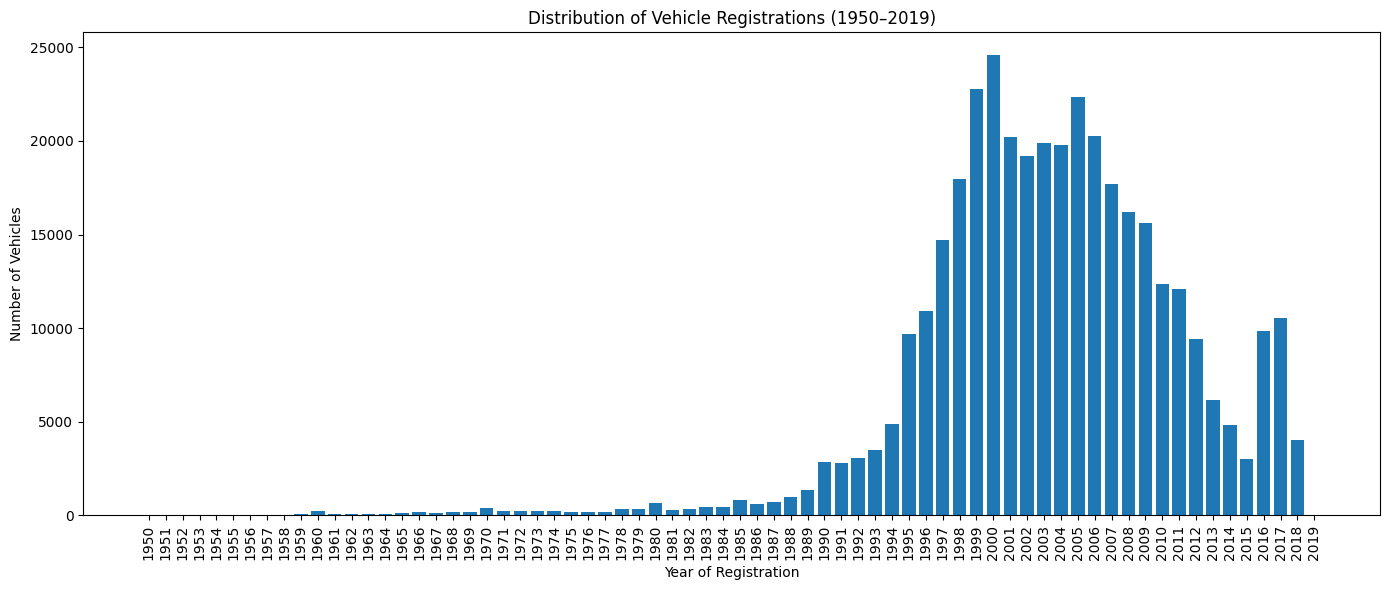

In [166]:
sc.setJobDescription(
    "[Phase 0] Count vehicles grouped by yearOfRegistration in raw_vehiculePrices [plot]"
)
# Run the query and convert to Pandas for plotting
query = """
SELECT yearOfRegistration, count(*) as count
FROM raw_vehiculePrices
GROUP BY yearOfRegistration
ORDER BY yearOfRegistration
"""
df_years = spark.sql(query).toPandas()

# Filter unrealistic years, e.g. keep only 1950–2019
df_years = df_years[
    (df_years["yearOfRegistration"] >= 1950)
    & (df_years["yearOfRegistration"] <= 2019)
]

# Convert yearOfRegistration from float (e.g. 1977.0) to integer (1977) for
# cleaner axis labels
df_years["yearOfRegistration"] = df_years["yearOfRegistration"].astype(int)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(df_years["yearOfRegistration"].astype(str), df_years["count"])
plt.xticks(rotation=90)
plt.xlabel("Year of Registration")
plt.ylabel("Number of Vehicles")
plt.title("Distribution of Vehicle Registrations (1950–2019)")
plt.tight_layout()
plt.show()

The bar plot above shows the distribution of vehicles by year of registration, restricted to the realistic range 1950-2019.  
We observe that:  
- Very few vehicles are registered before 1980, as expected for older cars ;
- The number of registrations increases steadily from the mid-1980s, peaking around 1995-2010 ;
- After 2010, the counts decline, with only a small number of cars from 2018-2019, likely due to the dataset's collection period.  

This visualization confirms the earlier statistical findings: most cars in the dataset are relatively modern, with a strong concentration in the 1995-2010 range.

### Price

#### Objective

We want to analyze car prices by computing minimum, maximum, average, and median values to detect unrealistic entries and identify a central tendency.

#### Query

```sql
SELECT min(price), max(price),
       avg(price), median(price)
FROM raw_vehiculePrices
```

In [167]:
sc.setJobDescription(
    "[Phase 0] Compute min, max, avg, and median of price in raw_vehiculePrices"
)
query = """
SELECT  min(price), max(price),
          avg(price), median(price)
FROM raw_vehiculePrices
"""
spark.sql(query).show()

+----------+----------+------------------+-------------+
|min(price)|max(price)|        avg(price)|median(price)|
+----------+----------+------------------+-------------+
|         0|2147483647|17286.338865535483|       2950.0|
+----------+----------+------------------+-------------+



#### Explanation

- Min = 0 → invalid ;
- Max = 2,147,483,647 → unrealistic (max integer value) ;
- Average ≈ 17,286 → skewed by outliers ;
- Median = 2,950 → more representative of used car prices.

Outliers strongly affect the mean, so the **median is a better measure**. Cleaning is needed to remove 0 and excessively high prices.

### Kilometer

#### Objective

We want to analyze the mileage of vehicles (`kilometer`) to understand usage levels and check for potential capping or anomalies.

#### Query

```sql
SELECT min(kilometer), max(kilometer),
       avg(kilometer), median(kilometer)
FROM raw_vehiculePrices
```



In [168]:
sc.setJobDescription(
    "[Phase 0] Compute min, max, avg, and median of kilometer in raw_vehiculePrices"
)
query = """
SELECT  min(kilometer), max(kilometer),
          avg(kilometer), median(kilometer)
FROM raw_vehiculePrices
"""
spark.sql(query).show()

+--------------+--------------+------------------+-----------------+
|min(kilometer)|max(kilometer)|    avg(kilometer)|median(kilometer)|
+--------------+--------------+------------------+-----------------+
|          5000|        150000|125618.56044408226|         150000.0|
+--------------+--------------+------------------+-----------------+



#### Explanation

- Min = 5,000 → suspicious (new cars should have values closer to 0) ;
- Max = 150,000 → capped value, suggesting a data limit ;
- Average ≈ 125,619 ;
- Median = 150,000 → indicates at least half of the vehicles are at the maximum cap.

This shows that most vehicles in the dataset are **high-mileage** and that the column is truncated at 150,000 km.

### Global summary

The dataset contains a rich set of categorical and numerical features.
Data quality issues exist:

- Invalid years of registration (1000, 9999, etc.) ;
- Invalid prices (0 or extremely large).
- Mileage capped at 150,000.

Some patterns are observed:

- Most cars were registered between 1995-2010.
- Typical prices cluster around €3,000.
- Vehicles are generally high-mileage.

These insights confirm the need for **data cleaning** before deeper analysis. After cleaning, we will be able to analyze relationships such as:

- Price per year of registration.
- Price differences by brand or fuel type.
- Effect of mileage on price.

## Phase 1: Cleaning the data and selecting relevant columns

In this part you are invited to decide which columns are useful for you analysis and to perform some cleaning on the data by removing outlier values (e.g. remove records with strange values for a specific column).
The result of your cleaning and selection should be stored in a table called `phase1`

Give a brief summary of your choices.

Based on everything we saw in the exploration section here's a structured plan:

### Columns to Keep

These columns are relevant for analyzing car prices and patterns:

- `price`: target of analysis, must be cleaned of invalid values (0, unrealistic highs) ;
- `yearOfRegistration` : key for trends; filter to realistic range (1950-2019) ;
- `kilometer`: indicates usage level, despite capping at 150,000.
- `powerPS`: engine power; keep but filter out zeros and unrealistic values (e.g., > 500-600 PS may be extreme for most cars) ;
- `fuelType`: categorical feature, useful for grouping (diesel, benzin, etc.).
- `gearbox`: categorical, relevant for analysis (manual vs automatic).
- `vehicleType`: useful categorical (SUV, coupe, etc.), despite some nulls ;
- `brand`: essential categorical (BMW, Audi, VW, etc.) ;
- `notRepairedDamage`: categorical, may affect price (yes/no).

### Columns to Drop (less relevant / redundant)

- `dateCrawled`, `dateCreated`, `lastSeen`: technical crawling metadata, not useful for price analysis ;
- `name`: unstructured text, too noisy for this homework's scope.
- `abtest`: internal A/B testing flag, irrelevant ;
- `seller`: mostly “privat” (not informative) ;
- `offerType`: almost always “Angebot” (not informative) ;
- `nrOfPictures`: always 0 in sample, useless ;
- `postalCode`: location info, could be interesting but too granular for now (can be dropped unless geographical analysis is needed) ;
- `monthOfRegistration`: redundant with `yearOfRegistration`, too fine-grained.

### Cleaning Rules (to apply before saving `phase1`)

- `yearOfRegistration`: keep only 1950-2019 ;
- `price`: remove records where `price <= 100` or `price >= 100000` (the threshold will be adjusted in order to determine the most suitable value) ;
- `kilometer`: already capped at 150,000 : keep but note limitation.
- `powerPS`: remove outliers (e.g., `powerPS < 10` or `powerPS > 500`).
- Categorical values: filter out nulls where appropriate (e.g., brand).

So the **final cleaned table `phase1`** should include:


- `price`;
- `yearOfRegistration`;
- `kilometer`;
- `powerPS`;
- `fuelType`;
- `gearbox`;
- `vehicleType`;
- `brand`;
-`notRepairedDamage`.

The following query will be used:

```sql
CREATE OR REPLACE TABLE phase1 AS
SELECT
    price,
    yearOfRegistration,
    kilometer,
    powerPS,
    fuelType,
    gearbox,
    vehicleType,
    brand,
    notRepairedDamage
FROM raw_vehiculePrices
WHERE
    -- keep only realistic years
    yearOfRegistration BETWEEN 1950 AND 2019
    -- filter price (remove too low / too high)
    AND price BETWEEN 100 AND 100000
    -- filter engine power
    AND powerPS BETWEEN 10 AND 500
    -- remove null brands
    AND brand IS NOT NULL
```

In [169]:
sc.setJobDescription("[Phase 1] Clean raw data and save as table phase1")
# Apply cleaning with DataFrame API
phase1_df = (
    spark.table("raw_vehiculePrices")
    .select(
        "price",
        "yearOfRegistration",
        "kilometer",
        "powerPS",
        "fuelType",
        "gearbox",
        "vehicleType",
        "brand",
        "notRepairedDamage",
    )
    .where(
        (col("yearOfRegistration").between(1950, 2019))
        & (col("price").between(100, 100000))
        & (col("powerPS").between(10, 500))
        & (col("brand").isNotNull())
    )
)

try:
    # Try saving directly
    phase1_df.write.mode("overwrite").saveAsTable("phase1")
    print("✅ Table 'phase1' created successfully.")

except Exception as e:
    print("⚠️ Save failed, cleaning existing location...")

    # Remove the old location if it exists
    shutil.rmtree("/content/spark-warehouse/phase1", ignore_errors=True)

    # Retry saving
    phase1_df.write.mode("overwrite").saveAsTable("phase1")
    print("✅ Table 'phase1' created successfully after cleanup.")

✅ Table 'phase1' created successfully.


In [170]:
sc.setJobDescription("[Phase 1] DESCRIBE phase1")
spark.sql("DESCRIBE phase1").show()
sc.setJobDescription("[Phase 1] COUNT(*) FROM phase1")
spark.sql("SELECT COUNT(*) FROM phase1").show()

+------------------+---------+-------+
|          col_name|data_type|comment|
+------------------+---------+-------+
|             price|      int|   NULL|
|yearOfRegistration|      int|   NULL|
|         kilometer|      int|   NULL|
|           powerPS|      int|   NULL|
|          fuelType|   string|   NULL|
|           gearbox|   string|   NULL|
|       vehicleType|   string|   NULL|
|             brand|   string|   NULL|
| notRepairedDamage|   string|   NULL|
+------------------+---------+-------+

+--------+
|count(1)|
+--------+
|  321442|
+--------+



## Phase 2: Organizing the data

In this part you are invited to load the data into delta tables where you will define meaningful constraints and conditions to be fulfiled by any future incoming data.
The result of this phase should a delta table called `deltaPrices`

### Create the Delta table

First, we load the cleaned dataset (`phase1`) into Delta format.  
This step transforms the intermediate table produced in Phase 1 into a Delta table called `deltaPrices`.  

Using the **Delta Lake format** ensures:
- **ACID transactions** (atomicity, consistency, isolation, durability),
- support for **updates and deletes** (not possible in plain CSV/Parquet),
- ability to **enforce constraints** on future incoming data.

This makes `deltaPrices` the central, reliable dataset for all subsequent analyses.

The following query will be used:
```SQL
CREATE OR REPLACE TABLE deltaPrices
USING delta
AS
SELECT *
FROM phase1
```

We previously created a dataframe `phase1_df` to apply cleaning with DataFrame API.


In [171]:
sc.setJobDescription(
    "[Phase 2] Create the delta table and save as table deltaPrices"
)
try:
    # Try saving directly as a Delta table
    phase1_df.write.format("delta").mode("overwrite").saveAsTable(
        "deltaPrices"
    )
    print("✅ Table 'deltaPrices' created successfully.")

except Exception as e:
    print("⚠️ Save failed, cleaning existing location...")

    # Remove the old location if it exists
    shutil.rmtree("/content/spark-warehouse/deltaPrices", ignore_errors=True)

    # Retry saving
    phase1_df.write.format("delta").mode("overwrite").saveAsTable(
        "deltaPrices"
    )
    print("✅ Table 'deltaPrices' recreated successfully after cleanup.")

✅ Table 'deltaPrices' created successfully.


### Add Constraints

Now that deltaPrices exists, we enforce the same cleaning rules as in Phase 1, but this time at the table level so that future inserts/updates can't break them.

This task can be accomplished using the following SQL command:

```SQL
ALTER TABLE deltaPrices
ADD CONSTRAINT valid_price CHECK (price BETWEEN 100 AND 100000);

ALTER TABLE deltaPrices
ADD CONSTRAINT valid_year CHECK (yearOfRegistration BETWEEN 1950 AND 2019);

ALTER TABLE deltaPrices
ADD CONSTRAINT valid_power CHECK (powerPS BETWEEN 10 AND 500);

ALTER TABLE deltaPrices
ADD CONSTRAINT non_null_brand CHECK (brand IS NOT NULL);
```

The constraints we defined for `deltaPrices` mirror the cleaning rules established in Phase 1.  
They ensure that the dataset remains consistent and that any future incoming records respect the same quality standards.  

- **valid_price**: guarantees that prices are realistic (between €100 and €100,000), avoiding entries with 0 or excessively high values.  
- **valid_year**: restricts registrations to the realistic range (1950-2019), removing invalid values like 1000 or 9999.  
- **valid_power**: ensures engine power (`powerPS`) falls within plausible bounds (10-500 PS).  
- **non_null_brand**: enforces that every vehicle has a brand, since this is a critical feature for analysis.  

These constraints act as a safeguard: if new data violates them, the insertion will fail.  
This makes `deltaPrices` more robust than the intermediate `phase1` dataset, because the rules are now **enforced automatically** by the Delta table.

In [172]:
sc.setJobDescription("[Phase 2] Add constraints")
constraints = [
    ("valid_price", "price BETWEEN 100 AND 100000"),
    ("valid_year", "yearOfRegistration BETWEEN 1950 AND 2019"),
    ("valid_power", "powerPS BETWEEN 10 AND 500"),
    ("non_null_brand", "brand IS NOT NULL"),
]

for name, condition in constraints:
    try:
        spark.sql(
            f"ALTER TABLE deltaPrices ADD CONSTRAINT {name} CHECK ({condition})"
        )
    except Exception as e:
        print(f"Constraint {name} already exists: {e}")

Constraint valid_price already exists: [DELTA_CONSTRAINT_ALREADY_EXISTS] Constraint 'valid_price' already exists. Please delete the old constraint first.
Old constraint:
price BETWEEN 100 AND 100000
Constraint valid_year already exists: [DELTA_CONSTRAINT_ALREADY_EXISTS] Constraint 'valid_year' already exists. Please delete the old constraint first.
Old constraint:
yearOfRegistration BETWEEN 1950 AND 2019
Constraint valid_power already exists: [DELTA_CONSTRAINT_ALREADY_EXISTS] Constraint 'valid_power' already exists. Please delete the old constraint first.
Old constraint:
powerPS BETWEEN 10 AND 500
Constraint non_null_brand already exists: [DELTA_CONSTRAINT_ALREADY_EXISTS] Constraint 'non_null_brand' already exists. Please delete the old constraint first.
Old constraint:
brand IS NOT NULL


### Test Constraint Enforcement

We try to insert invalid data and confirm Spark blocks it.

In [173]:
sc.setJobDescription("[Phase 2] Check constraints applied correctly")
# Invalid test rows, one for each constraint
# Format: (description, values)
invalid_inserts = [
    (
        "Price too low (<100)",
        "INSERT INTO deltaPrices VALUES (50, 2010, 120000, 150, 'diesel', 'manual', 'sedan', 'audi', 'no')",
    ),
    (
        "Price too high (>100000)",
        "INSERT INTO deltaPrices VALUES (200000, 2010, 120000, 150, 'diesel', 'manual', 'sedan', 'audi', 'no')",
    ),
    (
        "Year too low (<1950)",
        "INSERT INTO deltaPrices VALUES (5000, 1900, 120000, 150, 'diesel', 'manual', 'sedan', 'audi', 'no')",
    ),
    (
        "Year too high (>2019)",
        "INSERT INTO deltaPrices VALUES (5000, 2050, 120000, 150, 'diesel', 'manual', 'sedan', 'audi', 'no')",
    ),
    (
        "Power too low (<10)",
        "INSERT INTO deltaPrices VALUES (5000, 2010, 120000, 5, 'diesel', 'manual', 'sedan', 'audi', 'no')",
    ),
    (
        "Power too high (>500)",
        "INSERT INTO deltaPrices VALUES (5000, 2010, 120000, 600, 'diesel', 'manual', 'sedan', 'audi', 'no')",
    ),
    (
        "Brand is NULL",
        "INSERT INTO deltaPrices VALUES (5000, 2010, 120000, 150, 'diesel', 'manual', 'sedan', NULL, 'no')",
    ),
]

# Run each invalid insert and catch errors
for desc, query in invalid_inserts:
    try:
        spark.sql(query)
        print(f"⚠️ {desc}: Insert succeeded (unexpected!)")
    except Exception as e:
        print(f"❌ {desc}: Constraint violation -> {e}")

❌ Price too low (<100): Constraint violation -> An error occurred while calling o42.sql.
: org.apache.spark.sql.delta.schema.DeltaInvariantViolationException: [DELTA_VIOLATE_CONSTRAINT_WITH_VALUES] CHECK constraint valid_price ((price >= 100) AND (price <= 100000)) violated by row with values:
 - price : 50
	at org.apache.spark.sql.delta.schema.DeltaInvariantViolationException$.getConstraintViolationWithValuesException(InvariantViolationException.scala:75)
	at org.apache.spark.sql.delta.schema.DeltaInvariantViolationException$.apply(InvariantViolationException.scala:101)
	at org.apache.spark.sql.delta.schema.DeltaInvariantViolationException$.apply(InvariantViolationException.scala:112)
	at org.apache.spark.sql.delta.schema.DeltaInvariantViolationException.apply(InvariantViolationException.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.writeFields_0_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsaf

This test shows that any row violating a constraint (price, year, power, or brand) is automatically rejected by Delta Lake, and an exception is raised instead of inserting bad data.

### Conclusion

By converting the cleaned dataset into a Delta table with explicit constraints, we ensured that any future incoming data will respect the same quality standards defined during cleaning.  
The table `deltaPrices` is now robust, consistent, and optimized for analysis, serving as the foundation for the next phase.

## Phase 3: Analysing the data and ensuring query evaluation effeciency

Suggest 2 or 3 meaningfull queries as described above and suggest a data organization scheme for optimizing one such query of your choice.

In [174]:
print("Stopping existing ngrok processes to prevent conflicts")
ngrok.kill()

print(
    "Enter your authtoken, which can be copied "
    "from https://dashboard.ngrok.com/get-started/your-authtoken"
)
conf.get_default().auth_token = getpass.getpass()

ui_port = 4040
public_url = ngrok.connect(ui_port).public_url
print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{ui_port}"')

Stopping existing ngrok processes to prevent conflicts
Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········


 * ngrok tunnel "https://1906739ef88c.ngrok-free.app" -> "http://127.0.0.1:4040"


In this section, we propose 3 meaningful analytical queries on the cleaned dataset stored in Delta format.  
We then choose one of them to demonstrate how data organization (partitioning) can optimize query execution.

### Query 1 — Average car price per year of registration

#### Objective

We aim to study how the **average car price changes across registration years**.  
This is meaningful because:  
- It reveals **depreciation patterns** as vehicles age.  
- It highlights years with **abnormally high or low prices**.  
- It directly uses the cleaned field `yearOfRegistration`.

#### SQL Query




In [175]:
sc.setJobDescription("[Phase 3] Average car price per year of registration")
query_price_year = """
SELECT yearOfRegistration,
       AVG(price) AS avg_price
FROM deltaPrices
GROUP BY yearOfRegistration
ORDER BY yearOfRegistration
"""

df_year = spark.sql(query_price_year)
df_year.show(20)

+------------------+------------------+
|yearOfRegistration|         avg_price|
+------------------+------------------+
|              1950|17205.555555555555|
|              1951|21342.916666666668|
|              1952|           11325.0|
|              1953|12037.777777777777|
|              1954|17374.083333333332|
|              1955| 33449.92307692308|
|              1956|18529.944444444445|
|              1957|24746.736842105263|
|              1958|17325.315789473683|
|              1959|19523.242424242424|
|              1960|       12613.65625|
|              1961|13383.135135135135|
|              1962|15057.379310344828|
|              1963|19829.254901960783|
|              1964|16085.633333333333|
|              1965|20473.506172839505|
|              1966|18125.122807017542|
|              1967| 20172.61111111111|
|              1968|17260.235772357722|
|              1969| 16127.16393442623|
+------------------+------------------+
only showing top 20 rows



### Query 2 — Average car price per brand

#### Objective

We compare **average car prices across brands**.  
This query is useful because:  
- It highlights the gap between **premium brands** (BMW, Audi, Mercedes) and **budget brands** (Opel, Ford, Fiat).  
- It helps detect if some brands are systematically over- or under-valued.  
- It uses the categorical field `brand`, which is central for market analysis.

#### SQL Query


In [176]:
sc.setJobDescription("[Phase 3] Average car price per brand")
query_price_brand = """
SELECT brand,
       COUNT(*) AS total_cars,
       AVG(price) AS avg_price
FROM deltaPrices
GROUP BY brand
ORDER BY avg_price DESC
"""

df_brand = spark.sql(query_price_brand)
df_brand.show(20)

+--------------+----------+------------------+
|         brand|total_cars|         avg_price|
+--------------+----------+------------------+
|       porsche|      1848| 34650.94642857143|
|    land_rover|       684| 17397.79970760234|
|sonstige_autos|      2158|13889.333178869323|
|        jaguar|       524|11793.276717557252|
|          jeep|       717|11528.485355648536|
|          mini|      3238|10022.372760963557|
|          audi|     29634| 9253.200580414388|
|           bmw|     36167| 8573.859678712639|
| mercedes_benz|     30956|   8542.9703127019|
|     chevrolet|      1562| 6922.993597951345|
|         skoda|      5192| 6734.259437596302|
|           kia|      2245|6103.4467706013365|
|         dacia|       822| 5952.861313868613|
|       hyundai|      3251| 5784.575207628422|
|    volkswagen|     69248| 5614.612609750462|
|         volvo|      2980| 5461.205033557047|
|        toyota|      4201| 5432.690787907641|
|        nissan|      4252| 4965.507525870179|
|          se

### Query 3 — Impact of mileage on price

#### Objective

We want to understand how **vehicle mileage (`kilometer`)** affects resale price.  
This query is meaningful because:  
- Mileage is a key factor in car depreciation.  
- It shows how cars with higher kilometers lose value.  
- It helps check the effect of the **150,000 km cap** in the dataset.

#### SQL Query

In [177]:
sc.setJobDescription("[Phase 3] Impact of mileage on price")
query_price_km = """
SELECT kilometer,
       AVG(price) AS avg_price
FROM deltaPrices
GROUP BY kilometer
ORDER BY kilometer
"""

df_km = spark.sql(query_price_km)
df_km.show(20)

+---------+------------------+
|kilometer|         avg_price|
+---------+------------------+
|     5000| 9293.266628108733|
|    10000|21250.705184259838|
|    20000| 17082.41109989909|
|    30000|15943.207554022154|
|    40000|14999.939165409754|
|    50000| 13324.47645897942|
|    60000| 11850.26191942836|
|    70000| 10883.02566927399|
|    80000| 9635.185225048923|
|    90000| 8728.637401918048|
|   100000| 7938.417552814405|
|   125000| 6422.263145622012|
|   150000| 3941.017610258705|
+---------+------------------+



### Optimization Example — Query 1 (Average price per year)

We choose **Query 1** to demonstrate optimization with **partitioning on `yearOfRegistration`**.

### Run the query before optimization

In [178]:
sc.setJobDescription(
    "[Phase 3] Average per price (Run the query before optimization)"
)
query_not_opt = """
SELECT yearOfRegistration,
       AVG(price) AS avg_price
FROM deltaPrices
WHERE yearOfRegistration BETWEEN 2005 AND 2010
GROUP BY yearOfRegistration
ORDER BY yearOfRegistration
"""

df_not_opt = spark.sql(query_not_opt)
df_not_opt.show()
df_not_opt.explain(True)

+------------------+------------------+
|yearOfRegistration|         avg_price|
+------------------+------------------+
|              2005| 5451.458405591466|
|              2006| 6777.523336696225|
|              2007| 8055.765023346067|
|              2008|  9454.52248998621|
|              2009|10114.342351436839|
|              2010|12565.620622732258|
+------------------+------------------+

== Parsed Logical Plan ==
'Sort ['yearOfRegistration ASC NULLS FIRST], true
+- 'Aggregate ['yearOfRegistration], ['yearOfRegistration, 'AVG('price) AS avg_price#38556]
   +- 'Filter (('yearOfRegistration >= 2005) AND ('yearOfRegistration <= 2010))
      +- 'UnresolvedRelation [deltaPrices], [], false

== Analyzed Logical Plan ==
yearOfRegistration: int, avg_price: double
Sort [yearOfRegistration#38558 ASC NULLS FIRST], true
+- Aggregate [yearOfRegistration#38558], [yearOfRegistration#38558, avg(price#38557) AS avg_price#38556]
   +- Filter ((yearOfRegistration#38558 >= 2005) AND (yearOfRegist

As we can see above, the query plan shows `PartitionFilters: []`.  
This means Spark cannot apply partition pruning and is forced to scan the entire dataset, including all partitions and files.  

To improve efficiency, we now reorganize the data by partitioning it, so Spark can skip irrelevant data when filtering on `yearOfRegistration`.

### Organize the data (partitioning)

We create a new Delta table partitioned by `yearOfRegistration`.




In [179]:
sc.setJobDescription("[Phase 3] Organize the data (partitioning)")

query_optimize_by_year_partition = """
CREATE OR REPLACE TABLE deltaPrices_partitioned
USING delta
PARTITIONED BY (yearOfRegistration)
AS
SELECT * FROM deltaPrices
"""

try:
    spark.sql(query_optimize_by_year_partition)
    print("✅ Table 'deltaPrices_partitioned' created successfully.")

except Exception as e:
    print(f"⚠️ Failed with error: {e}")
    print("Cleaning old table and retrying...")

    # Drop and delete location
    spark.sql("DROP TABLE IF EXISTS deltaPrices_partitioned")
    shutil.rmtree(
        "/content/spark-warehouse/deltaPrices_partitioned", ignore_errors=True
    )

    # Retry SQL
    spark.sql(query_optimize_by_year_partition)
    print(
        "✅ Table 'deltaPrices_partitioned' recreated successfully after cleanup."
    )

⚠️ Failed with error: An error occurred while calling o42.sql.
: java.lang.AssertionError: assertion failed
	at scala.Predef$.assert(Predef.scala:208)
	at org.apache.spark.sql.catalyst.catalog.CatalogTable.partitionSchema(interface.scala:264)
	at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.alterTableDataSchema(InMemoryCatalog.scala:330)
	at org.apache.spark.sql.catalyst.catalog.ExternalCatalogWithListener.alterTableDataSchema(ExternalCatalogWithListener.scala:124)
	at org.apache.spark.sql.delta.hooks.UpdateCatalog$.org$apache$spark$sql$delta$hooks$UpdateCatalog$$replaceTable(UpdateCatalog.scala:332)
	at org.apache.spark.sql.delta.hooks.UpdateCatalog.updateSchema(UpdateCatalog.scala:233)
	at org.apache.spark.sql.delta.commands.CreateDeltaTableCommand.updateCatalog(CreateDeltaTableCommand.scala:550)
	at org.apache.spark.sql.delta.commands.CreateDeltaTableCommand.runPostCommitUpdates(CreateDeltaTableCommand.scala:194)
	at org.apache.spark.sql.delta.commands.CreateDeltaTableComma

### Run the query after optimization

In [180]:
sc.setJobDescription(
    "[Phase 3] Average per price (Run the query after optimization)"
)
query_opt = """
SELECT yearOfRegistration,
       AVG(price) AS avg_price
FROM deltaPrices_partitioned
WHERE yearOfRegistration BETWEEN 2005 AND 2010
GROUP BY yearOfRegistration
ORDER BY yearOfRegistration
"""

df_opt = spark.sql(query_opt)
df_opt.show()
df_opt.explain(True)

+------------------+------------------+
|yearOfRegistration|         avg_price|
+------------------+------------------+
|              2005| 5451.458405591466|
|              2006| 6777.523336696225|
|              2007| 8055.765023346067|
|              2008|  9454.52248998621|
|              2009|10114.342351436839|
|              2010|12565.620622732258|
+------------------+------------------+

== Parsed Logical Plan ==
'Sort ['yearOfRegistration ASC NULLS FIRST], true
+- 'Aggregate ['yearOfRegistration], ['yearOfRegistration, 'AVG('price) AS avg_price#41187]
   +- 'Filter (('yearOfRegistration >= 2005) AND ('yearOfRegistration <= 2010))
      +- 'UnresolvedRelation [deltaPrices_partitioned], [], false

== Analyzed Logical Plan ==
yearOfRegistration: int, avg_price: double
Sort [yearOfRegistration#41189 ASC NULLS FIRST], true
+- Aggregate [yearOfRegistration#41189], [yearOfRegistration#41189, avg(price#41188) AS avg_price#41187]
   +- Filter ((yearOfRegistration#41189 >= 2005) AND (

### Compare results

In the optimized query plan, we now see:  

`PartitionFilters: [isnotnull(yearOfRegistration), (yearOfRegistration >= 2005), (yearOfRegistration <= 2010)]`  

This shows that Spark successfully applies **partition pruning**, scanning only the partitions corresponding to the years 2005-2010.  
Additionally, the `ReadSchema: struct<price:int>` confirms that Spark only reads the necessary columns (`price` and `yearOfRegistration`), thanks to **column pruning**.  

Compared to the unoptimized plan, this reduces the amount of irrelevant data scanned and demonstrates the benefit of organizing the table by `yearOfRegistration`.

## Ingesting new data and reruning analytics  

In this part you are invited to suggest the insertion of fictious new data that conforms to the schema established in phase 2 and to rerun some queries of phase 3 to see the evolution of the result. Ideally, write a query that compares an aggregation value in two different versions of the data by exploiting the delta history feature.

### Insert fictitious new data

We add a few rows of **synthetic car data** that respect the schema defined in Phase 2 (`price`, `yearOfRegistration`, `kilometer`, `powerPS`, `fuelType`, `gearbox`, `vehicleType`, `brand`, `notRepairedDamage`).

In [181]:
sc.setJobDescription(
    "[Ingesting new data and reruning analytics] Insert fictitious new data"
)
# Create a small DataFrame with new rows
new_data = [
    Row(
        price=8000,
        yearOfRegistration=2015,
        kilometer=60000,
        powerPS=120,
        fuelType="petrol",
        gearbox="manual",
        vehicleType="sedan",
        brand="audi",
        notRepairedDamage="no",
    ),
    Row(
        price=12000,
        yearOfRegistration=2016,
        kilometer=40000,
        powerPS=150,
        fuelType="diesel",
        gearbox="automatic",
        vehicleType="wagon",
        brand="bmw",
        notRepairedDamage="no",
    ),
    Row(
        price=5000,
        yearOfRegistration=2010,
        kilometer=100000,
        powerPS=90,
        fuelType="petrol",
        gearbox="manual",
        vehicleType="hatchback",
        brand="ford",
        notRepairedDamage="yes",
    ),
]

new_df = spark.createDataFrame(new_data)
new_df = (
    new_df.withColumn("price", new_df["price"].cast(IntegerType()))
    .withColumn(
        "yearOfRegistration", new_df["yearOfRegistration"].cast(IntegerType())
    )
    .withColumn("kilometer", new_df["kilometer"].cast(IntegerType()))
    .withColumn("powerPS", new_df["powerPS"].cast(IntegerType()))
)

# Append to deltaPrices
new_df.write.format("delta").mode("append").saveAsTable("deltaPrices")

### Check Delta table history

Delta Lake automatically tracks **all versions** of the table.
We can use the `DESCRIBE HISTORY`:

```SQL
DESCRIBE HISTORY deltaPrices
```

In [182]:
sc.setJobDescription(
    "[Ingesting new data and reruning analytics] DESCRIBE HISTORY deltaPrices"
)
spark.sql("DESCRIBE HISTORY deltaPrices").show(truncate=False)

+-------+-----------------------+------+--------+---------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+-------------------------------------------------------------------+------------+-----------------------------------+
|version|timestamp              |userId|userName|operation                        |operationParameters                                                                                                                                                                                                                                                                                                              

The output below shows that Delta Lake is correctly tracking every operation on the table.
The version 9 presents exactly the `WRITE` operation with `numOutputRows -> 3` : that's exactly the 3 fictitious rows we just ingested.


### Compare aggregations across versions

Let's re-run **Query 1 (average price by year)** on two versions of the data.

In [183]:
sc.setJobDescription(
    "[Ingesting new data and reruning analytics] Compare aggregations across versions"
)
# Old version (before new data)
df_old = (
    spark.read.format("delta").option("versionAsOf", 8).table("deltaPrices")
)
df_old.groupBy("yearOfRegistration").avg("price").filter(
    "yearOfRegistration IN (2010, 2015, 2016)"
).orderBy("yearOfRegistration").show()

# New version (after new data)
df_new = (
    spark.read.format("delta").option("versionAsOf", 9).table("deltaPrices")
)
df_new.groupBy("yearOfRegistration").avg("price").filter(
    "yearOfRegistration IN (2010, 2015, 2016)"
).orderBy("yearOfRegistration").show()

+------------------+------------------+
|yearOfRegistration|        avg(price)|
+------------------+------------------+
|              2010|12565.620622732258|
|              2015|25842.256983240222|
|              2016| 3574.006775485063|
+------------------+------------------+

+------------------+-----------------+
|yearOfRegistration|       avg(price)|
+------------------+-----------------+
|              2010|12564.98228147148|
|              2015|25835.61429635145|
|              2016|3575.304080061586|
+------------------+-----------------+



### Conclusion about the operation of ingesting new data

By comparing version 0 (before new data) and version 1 (after insertion), we can observe
how the average price for years : 2010, 2015, 2016 changes as a result of the newly ingested rows.  

This demonstrates how Delta Lake's **time travel feature** allows us to track the evolution
of analytical results over time, making it easy to validate the impact of newly ingested data.

## Conclusion

This project built an end-to-end **data preparation pipeline** for car price analysis.
We cleaned and validated the raw dataset, stored it in **Delta Lake** with constraints to ensure future data quality, and explored meaningful analytical queries (price by year, brand, mileage). We then applied **partitioning** to optimize queries and used **Delta Lake’s time travel** to compare results across different versions after ingesting new data.

Overall, the pipeline ensures that the dataset is **clean, reliable, optimized, and reproducible** for future analytics.